# Tutorial 02

## assembling the ABS pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import logging as log
import afra as af
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### generate maps with pysm3

In [2]:
NSIDE = 128

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

fwhm = dict()
fwhm[23] = 0.5*np.pi/180.
fwhm[95] = 0.3*np.pi/180.
fwhm[150] = 0.2*np.pi/180.
fwhm[353] = 0.08*np.pi/180.

fullmap = dict()
fullmap[23] = hp.smoothing(map23f+mapcmb,fwhm=fwhm[23],verbose=0)
fullmap[95] = hp.smoothing(map95f+mapcmb,fwhm=fwhm[95],verbose=0)
fullmap[150] = hp.smoothing(map150f+mapcmb,fwhm=fwhm[150],verbose=0)
fullmap[353] = hp.smoothing(map353f+mapcmb,fwhm=fwhm[353],verbose=0)

#### use `abspipe` (short for ABS pipeline) with map matrix input

#### `abspipe` (initialization/instantiation) Parameters: 

**singals** : dict
> The full collection of measurements in pixel domain,
  arranged in form {frequency (GHz): array(N_map, N_pixel)}.
    - N_map: number of maps at each frequency
    - N_pixel: number of pixels of each map
    
**variances** : dict
> The measured noise variance maps,
  should be arranged in the same shape as **signal**.
  By default, no variance maps required.
  
**mask** : numpy.ndarray
> Single mask map,
  should be arranged in shape: (1, N_pixel),
  By default is None, which means no masking.

**fwhms** : list
> Gaussian beams with given FWHM at each frequency band

**lmin** : integer
> Minimal multipole in PS estimation.
            
**lmax** : integer
> Maximal multipole in PS estimation.

#### `abspipe::run()` arguments:

**aposcale** : float
> Apodization scale for PS estimation.

**psbin** : integer
> number of angular modes in each $\ell$-bin for pseudo-$C_\ell$ estimation

**shift** : float
> ABS method (CMB signal) shift parameter.

**threshold** : float
> ABS method signal-to-noise threshold parameter.

####  `abspipe::run()` returns:

**result** : (numpy.ndarray, dict)
> The first row contains angular mode positions, while the second row contains the PS band power $D_\ell$ at corresponding multipoles.

> If `debug=True`, then the **result** contains an extra dictionary of eigen values and eigen vectors for each multipole, in form {'type': {multipole index : (eigen values, eigen vectors)}}.

- T mode

CPU times: user 22.6 s, sys: 79 ms, total: 22.7 s
Wall time: 3.12 s


(1, 384)

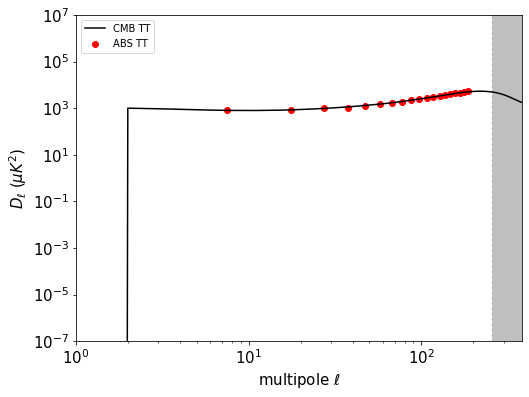

In [3]:
%%time

pipeline = af.abspipe(fullmap,fwhms=fwhm,targets='T')
pipeline.debug=True
signal, fiducial, noise = pipeline.preprocess(aposcale=6.,psbin=10,lmin=3,lmax=200)
modes, rslt_t, info_t = pipeline.analyse(signal,noise,shift=None,threshold=None)

fig,ax = plt.subplots(figsize=(8,6))

ax.scatter(modes,rslt_t[0],
           color='red',marker='o',label=r'ABS TT')

ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[0],
        color='black',linestyle='-',label=r'CMB TT')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

- check the eigens in cross-correlated PS band power

the eigen values and vectors are returned as a python dict, attached to the normal return of pipeline's `__call__` function, in form: `{mode #: (eigen value, eigen vector)}`

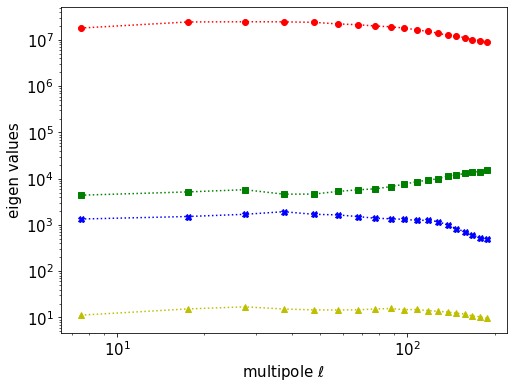

In [4]:
fig,ax = plt.subplots(figsize=(8,6))
freq_list = [23,95,150,353]

eigens = np.empty((len(freq_list),len(modes)))
for i in range(eigens.shape[1]):
    eigens[:,i] = info_t['T'][i][0]

ax.plot(modes,eigens[0],linestyle=':',color='r',marker='o')
ax.plot(modes,eigens[1],linestyle=':',color='g',marker='s')
ax.plot(modes,eigens[2],linestyle=':',color='b',marker='X')
ax.plot(modes,eigens[3],linestyle=':',color='y',marker='^')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'multipole $\ell$', fontsize=15)
ax.set_ylabel(r'eigen values', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

- E mode

CPU times: user 3min, sys: 548 ms, total: 3min
Wall time: 24.4 s


(1, 384)

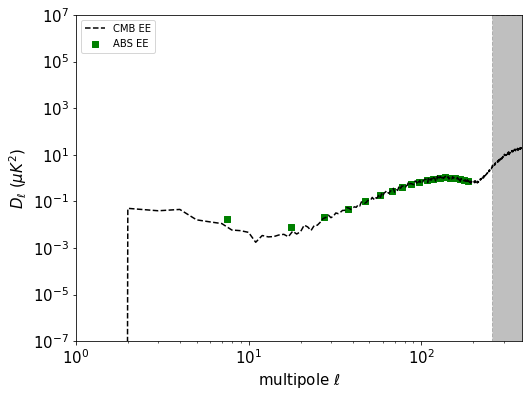

In [5]:
%%time

pipeline = af.abspipe(fullmap,fwhms=fwhm,targets='E')
pipeline.debug = True
signal, fiducial, noise = pipeline.preprocess(aposcale=6.,psbin=10,lmin=3,lmax=200)
modes, rslt_e, info_e = pipeline.analyse(signal,noise,shift=None,threshold=None)

fig,ax = plt.subplots(figsize=(8,6))

ax.scatter(modes,rslt_e[0],
           color='green',marker='s',label=r'ABS EE')

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(cmb_cl.shape[1])
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[1],
        color='black',linestyle='--',label=r'CMB EE')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

- B mode, with EB leakage correction done before PS estimation

CPU times: user 3min 11s, sys: 440 ms, total: 3min 12s
Wall time: 25.7 s


(1, 384)

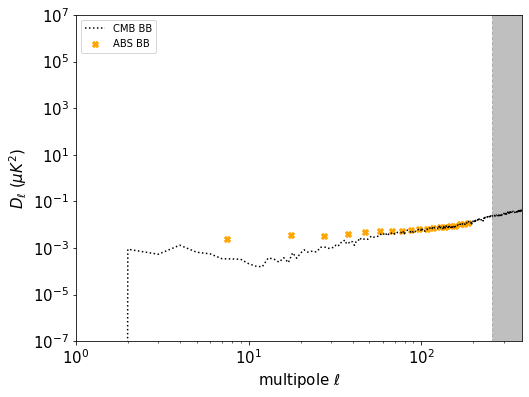

In [6]:
%%time

pipeline = af.abspipe(fullmap,fwhms=fwhm,targets='B')
pipeline.debug = False
signal, fiducial, noise = pipeline.preprocess(aposcale=6.,psbin=10,lmin=3,lmax=200)
modes, rslt_b, info_b = pipeline.analyse(signal,noise,shift=None,threshold=None)

fig,ax = plt.subplots(figsize=(8,6))

ax.scatter(modes,rslt_b[0],
           color='orange',marker='X',label=r'ABS BB')

ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[2],
        color='black',linestyle=':',label=r'CMB BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

end